<a href="https://colab.research.google.com/github/microprediction/winning/blob/main/splitting_race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install winning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Computing winning probabilities numerically by splitting a race

Here's the idea. First lets' set up a contest where there are really good and really bad contestants. 

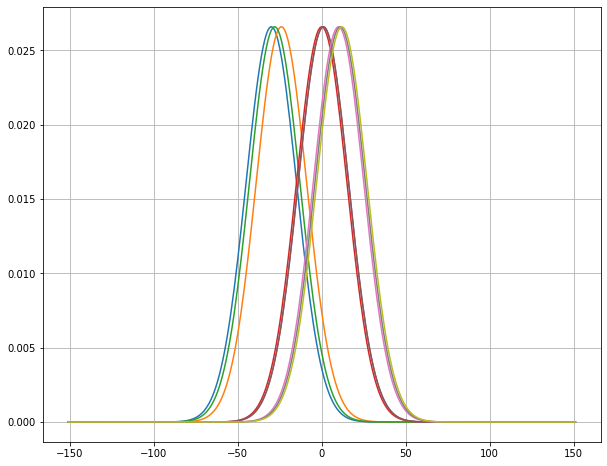

In [18]:
from winning.lattice import int_centered
from winning.lattice import state_prices_from_offsets, state_prices_from_extended_offsets
from winning.std_calibration import centered_std_density
import numpy as np
from winning.lattice import densities_from_offsets
from winning.lattice_plot import densitiesPlot
offsets_1=[-30, -24, -28, 0,1,1]
offsets_2=[10,11,12]
density = centered_std_density(L=151, unit=1.0, scale=15.0)
finite_offsets=offsets_1 + offsets_2 
densities = densities_from_offsets(density=density,offsets=finite_offsets)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
densitiesPlot(densities, unit=1.0)


Notice that I used a lattice of length 131. But we'll see how to make this work using lattices of smaller size.

In [27]:
from winning.lattice import dilate_density

def _state_prices_from_clustered_offsets(density, offsets, fast_ndxs:[int], unit_ratio):
    """
         Helper to deal with lattice limitations
         This splits the race into two groups and then
         uses a dilated density to estimate the winning
         share of the lessor group
    :param density: 
    :param offsets: 
    :param unit_ratio: 
    :param fast_ndxs:    Indexes of fast horses 
    :return: 
    """
    n = len(offsets)
    slow_ndxs = [ j for j in range(n) if j not in fast_ndxs ]
    if not slow_ndxs:
        return state_prices_from_offsets(density=density, offsets=offsets)
    else:
        if len(slow_ndxs) == 1:
            slow_relative_state_prices = [1.0]
        else:
            slow_offsets = [offsets[i] for i in slow_ndxs]
            slow_relative_state_prices = state_prices_from_offsets(density=density,
                                                                           offsets=int_centered(slow_offsets))
        fast_ndxs = [j for j in range(n) if j not in slow_ndxs]
        fast_offsets = [offsets[j] for j in fast_ndxs]
        fast_relative_state_prices = state_prices_from_offsets(density=density,
                                                                         offsets=int_centered(fast_offsets))

        # Create approximate race involving everyone
        dilated_density = dilate_density(density=density, unit_ratio=unit_ratio)
        dilated_offsets = [o/unit_ratio for o in offsets]
        dilated_state_prices = state_prices_from_offsets(density=dilated_density, offsets=dilated_offsets)
        slow_share = sum([p for i, p in enumerate(dilated_state_prices) if i in slow_ndxs])
        fast_share = 1 - slow_share
        slow_prices = [p * slow_share for p in slow_relative_state_prices]
        fast_prices = [p * fast_share for p in fast_relative_state_prices]
        state_prices = [0 for _ in range(n)]
        for i, ndx in enumerate(slow_ndxs):
            state_prices[ndx] = slow_prices[i]
        for i, ndx in enumerate(fast_ndxs):
            state_prices[ndx] = fast_prices[i]
        if not abs(sum(state_prices) - 1) < 1e-3:
            print({'sum(state_prices)':sum(state_prices)})
            raise ValueError('lattice line 579')
        return state_prices


Here goes...

In [29]:
fast_ndxs = [0,1,2] # The first three are the best 
prices = _state_prices_from_clustered_offsets(density, offsets=finite_offsets, fast_ndxs=fast_ndxs, unit_ratio=3)
prices

[0.39001833662637325,
 0.23356925607805784,
 0.33092463388586385,
 0.011949852274793267,
 0.010895590935613788,
 0.010895590935613788,
 0.0043308194329725255,
 0.0038665366095683384,
 0.0034440171571710016]

What's going on? Simple really. 